In [1]:
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  # create_foreshock_aftershock_dataloaders,
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
# from seisbench.generate.augmentation import Normalize
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 4
BATCH_SIZE = 8
EVENT_SPLIT_METHOD = 'temporal'
COMPONENT_ORDER = 'ZNE'
DIMENSION_ORDER = 'NCW'

# Examine the loader


In [3]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=NUM_CLASSES,
  batch_size=BATCH_SIZE,
  event_split_method=EVENT_SPLIT_METHOD,
  component_order=COMPONENT_ORDER,
  standardize=True,
)


Seed set to 42
Seed set to 42


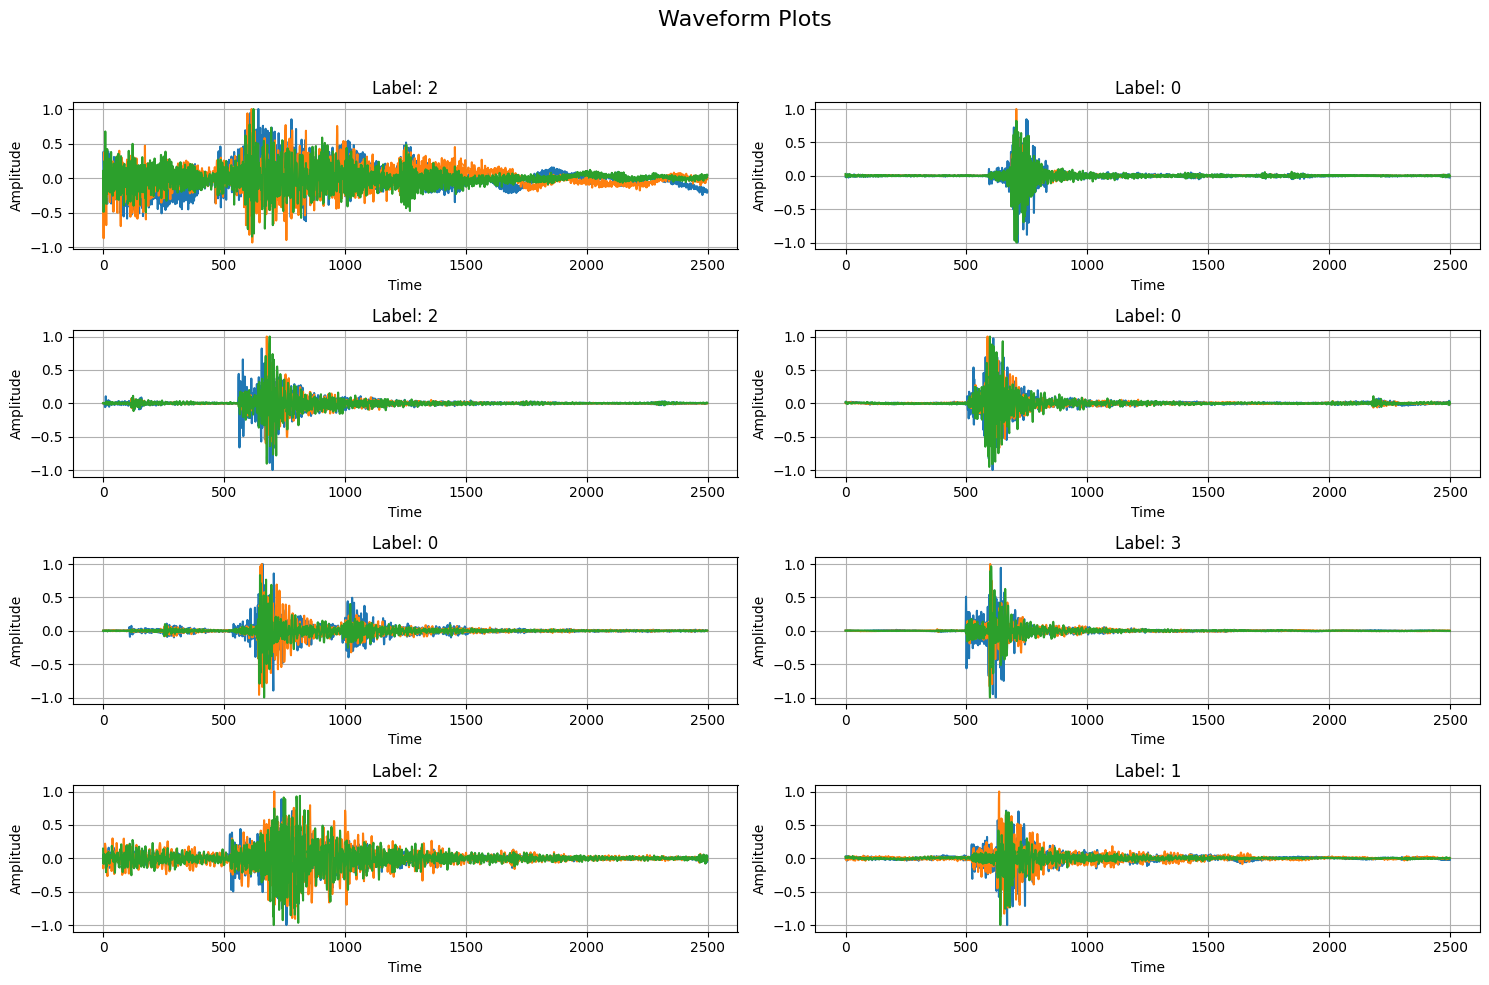

In [4]:
waveforms, labels = next(iter(loaders['train']))

# Create a figure with 8 subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
fig.suptitle('Waveform Plots', fontsize=16)

# Plot each waveform in a separate subplot
for i in range(8):
    ax = axs[i // 2, i % 2]  # Compute subplot index
    ax.plot(waveforms[i].T)
    ax.set_title(f'Label: {labels[i].item()}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [17]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import ShockClassifierLit #Wav2Vec2ForSequenceClassification

config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)

config.model_args.num_classes = NUM_CLASSES
config.model_args.use_weighted_layer_sum = True

model = ShockClassifierLit(
  model_name='Wav2Vec2ForSequenceClassification',
  model_config=config.model_args,
  max_train_steps=1,
  ).model



X, y = next(iter(loaders['train']))
model(X)

Wav2Vec2BaseModelOutput(last_hidden_state=tensor([[[ 4.1042e-01, -4.6194e-01, -1.8577e-01,  ..., -2.2279e-01,
           4.2981e-01,  1.3050e-01],
         [ 3.5475e-02, -8.3383e-02, -1.0722e-01,  ..., -1.0785e-01,
           1.6100e-01, -6.9057e-02],
         [ 1.4753e-01, -3.6426e-01, -4.0526e-01,  ..., -1.4936e-01,
           4.1998e-01, -2.1978e-02],
         ...,
         [ 9.0938e-01, -2.1163e+00,  7.2097e-01,  ...,  5.8840e-01,
           1.9431e-01,  7.8768e-02],
         [ 8.6445e-01, -2.0374e+00,  7.1512e-01,  ...,  5.3619e-01,
           2.2739e-01,  1.1879e-01],
         [ 9.6617e-01, -2.1063e+00,  7.6506e-01,  ...,  5.9229e-01,
           2.1552e-01,  1.7107e-01]],

        [[ 6.6268e-01, -7.8118e-01, -1.6126e-01,  ..., -5.0964e-01,
           2.1220e-01,  1.8966e-01],
         [ 4.2849e-01, -5.1277e-01, -1.3242e-01,  ..., -2.3850e-01,
           6.9783e-02, -5.4629e-02],
         [ 1.6958e-01, -5.8779e-01, -7.6818e-02,  ...,  7.1729e-02,
           8.7401e-02, -1.1973e-01

TypeError: 'Wav2Vec2BaseModelOutput' object is not subscriptable

In [6]:
config

data_args:
  batch_size: 64
  component_order: ZNE
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  seed: 42
  standardize: true
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  classifier_proj_size: 256
  learning_rate: 0.001
  num_classes: 4
  pretrained_ckpt_path: /scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-07-06-11h-30m-09s/checkpoints/epoch=22-step=604624.ckpt
  weight_decay: 0.01
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 100
  strategy: ddp
  unfreeze_base_at_epoch: 20

# examine the dataset directly


In [7]:
  datasets = create_foreshock_aftershock_datasets(
    num_classes=NUM_CLASSES,
    event_split_method=EVENT_SPLIT_METHOD,
    component_order=COMPONENT_ORDER,
    dimension_order=DIMENSION_ORDER,
    seed=42,
    # train_frac=train_frac,
    # val_frac=val_frac,
    # test_frac=test_frac,
  )


Seed set to 42
Seed set to 42


In [8]:
datasets['train'].keys()

dict_keys(['X', 'y', 'occurence_time'])

In [9]:
# datasets['train']['X'].shape# Number of classes
import numpy as np
X = datasets['train']['X']
y = datasets['train']['y']

num_classes = len(np.unique(y))

# Initialize a dictionary to store categorized data
categorized_X = {i: datasets['train']['X'][y == i] for i in range(num_classes)}
# categorized_time = {i: datasets['train']['occurence_time'][y == i] for i in range(num_classes)}
categorized_y = {i: datasets['train']['y'][y == i] for i in range(num_classes)}
categorized_time = {i: np.array(datasets['train']['occurence_time'])[y == i] for i in range(num_classes)}


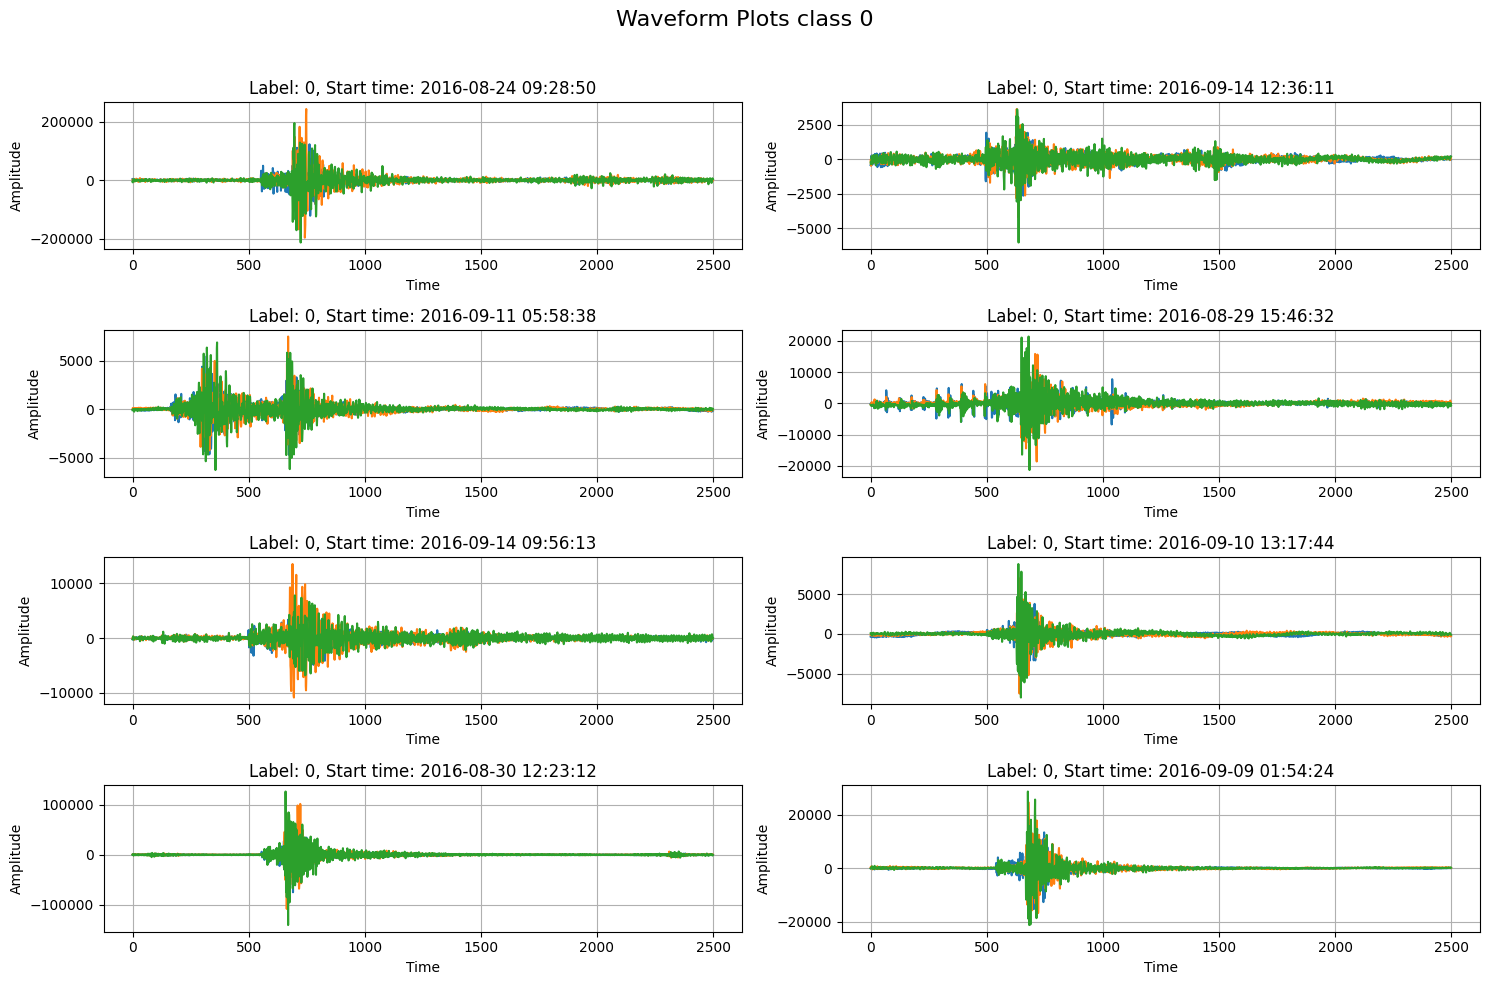

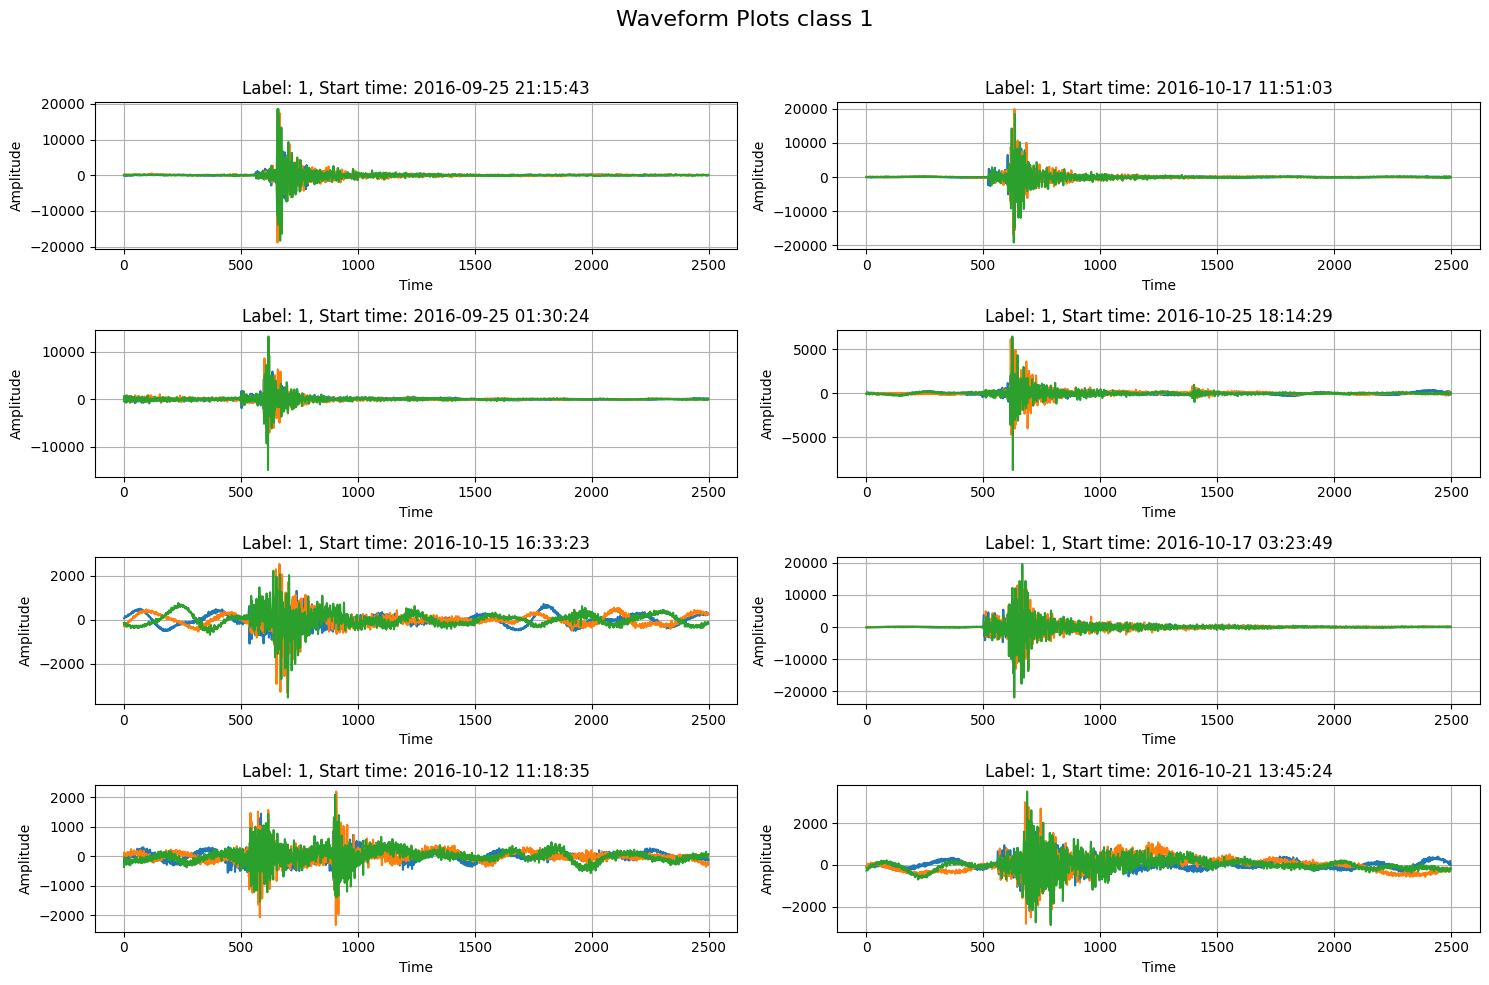

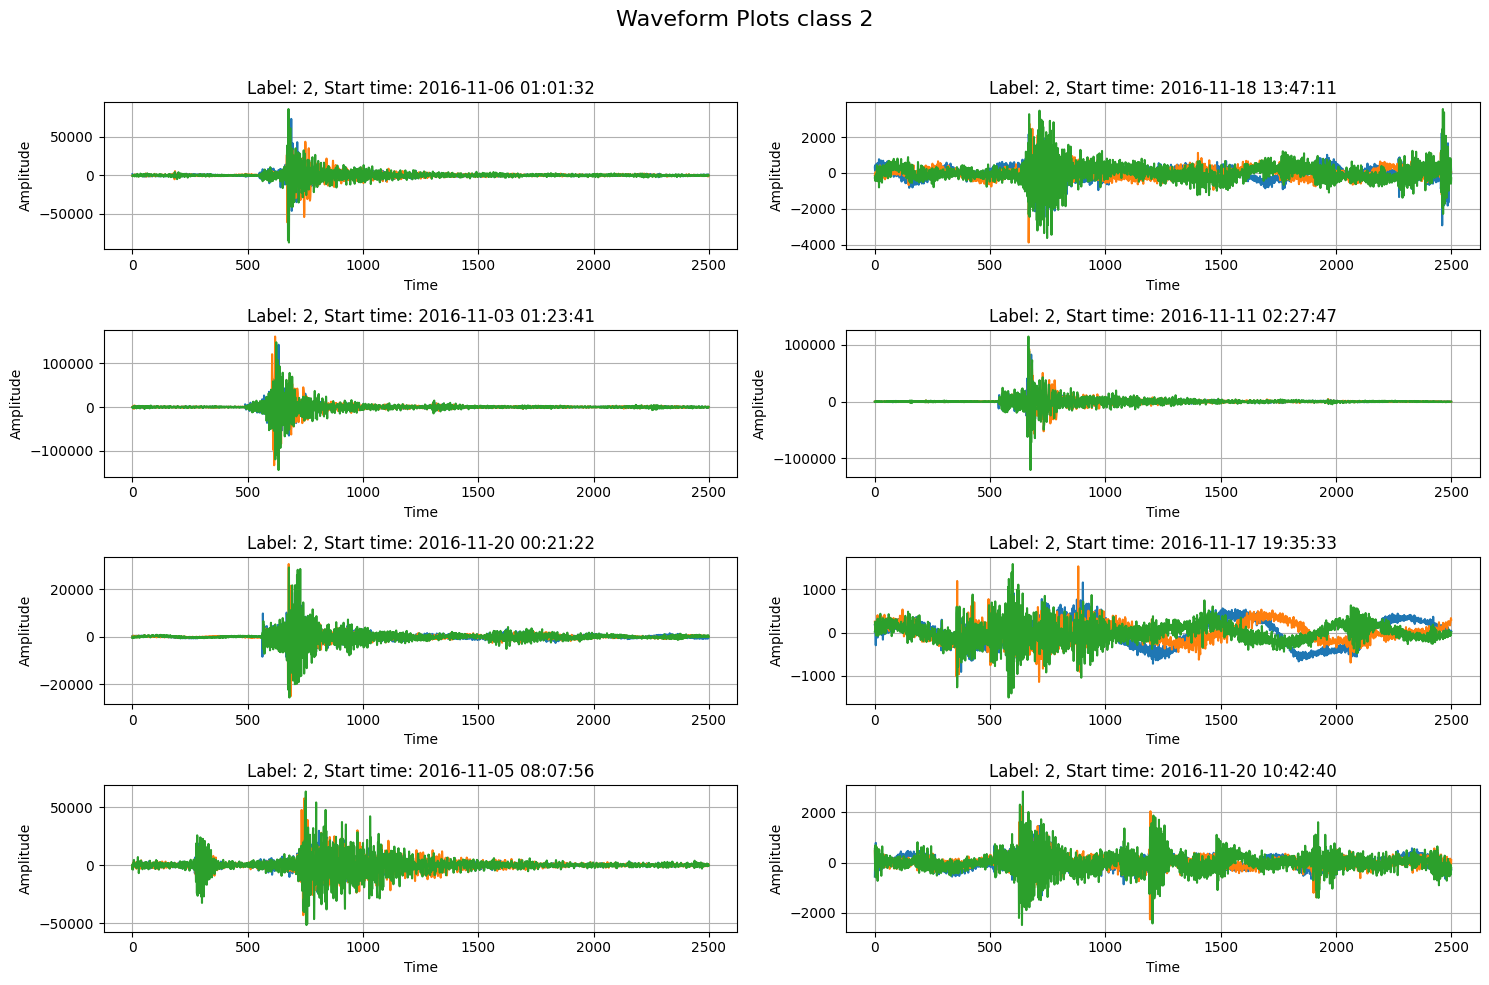

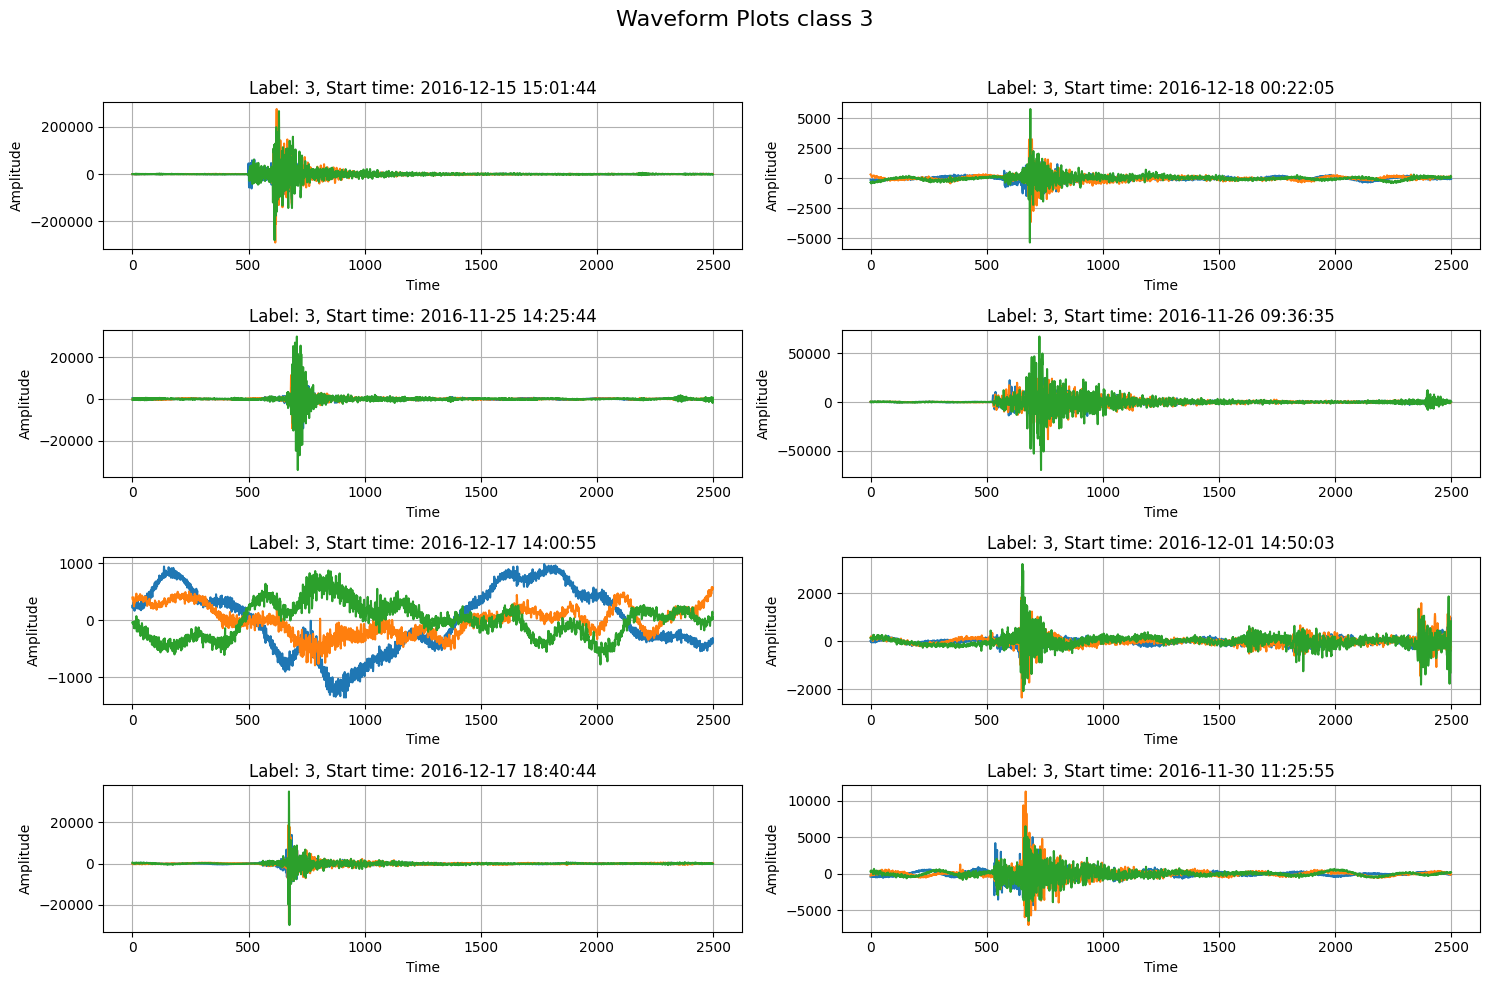

In [10]:

for j in range(NUM_CLASSES):
  fig, axs = plt.subplots(4, 2, figsize=(15, 10))
  fig.suptitle(f'Waveform Plots class {j}', fontsize=16)

  waveforms = categorized_X[j]
  labels = categorized_y[j]

  # Plot each waveform in a separate subplot
  for i in range(8):
      ax = axs[i // 2, i % 2]  # Compute subplot index
      ax.plot(waveforms[i].T)
      ax.set_title(f'Label: {labels[i].item()}, Start time: {categorized_time[j][i]}')
      ax.set_xlabel('Time')
      ax.set_ylabel('Amplitude')
      ax.grid(True)

  # Adjust layout for better spacing
  plt.tight_layout(rect=[0, 0, 1, 0.96])


In [11]:
categorized_X[0].shape

(1268, 3, 2500)

In [12]:
# np.sort(categorized_time[2])



In [13]:
from torchinfo import summary

# model = ConvNet()
# batch_size = 16

# summary(model, input_size=(8, 3, 2500))
# summary(model, input_size=(batch_size, 1, 28, 28))

In [14]:
X.shape

(5072, 3, 2500)

In [15]:
1/8

0.125